In [1]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/daily.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE            datetime64[ns]
TEAMNAME                object
USERCOUNT                int64
SECONDSSPENT             int64
QUANTITY                 int64
VOLUME                 float64
WEIGHT                 float64
PRICE                  float64
dtype: object

In [3]:
df = df[df['DATE'] > '2022-08-10']

In [4]:
teams = df['TEAMNAME'].unique()
df_multi_index = pd.MultiIndex.from_product([df['DATE'].unique(),
                                   teams], names=['DATE', 'TEAMNAME'])
df = df.set_index(['DATE', 'TEAMNAME']).reindex(df_multi_index, fill_value=0).reset_index()
df = df[df['TEAMNAME'] != 'ID9']

In [5]:
codes = dict(zip(df['TEAMNAME'].unique(), range(1, len(df['TEAMNAME'].unique())+1)))
df['TEAMNAME'] = df['TEAMNAME'].map(codes)
print(codes)
df

{'DP2': 1, 'DP1': 2, 'HP1': 3, 'DD': 4, 'HP2': 5, 'HD': 6}


,DATE,TEAMNAME,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
0,2022-08-16,1,1,552,28,0.812385,77.656000,608.40
1,2022-08-16,2,14,24312,1536,4.698062,528.972000,7106.06
2,2022-08-16,3,0,0,0,0.000000,0.000000,0.00
3,2022-08-16,4,0,0,0,0.000000,0.000000,0.00
4,2022-08-16,5,0,0,0,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...
2087,2023-09-29,2,50,629794,386483,1182.841185,124143.482703,663067.42
2088,2023-09-29,3,1,784,46145,127.654466,14000.372667,69089.23
2089,2023-09-29,4,7,6695,332128,1090.899987,115141.810667,770403.11
2090,2023-09-29,5,3,9210,88845,288.663179,31449.018000,171143.45


In [6]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,TEAMNAME,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
TEAMNAME,1.000000,-0.767246,-0.714005,-0.430706,-0.530093,-0.505770,-0.447103
USERCOUNT,-0.767246,1.000000,0.956668,0.542850,0.625968,0.604338,0.548369
SECONDSSPENT,-0.714005,0.956668,1.000000,0.565439,0.636814,0.623241,0.560882
QUANTITY,-0.430706,0.542850,0.565439,1.000000,0.874067,0.938353,0.609883
VOLUME,-0.530093,0.625968,0.636814,0.874067,1.000000,0.977215,0.723193
WEIGHT,-0.505770,0.604338,0.623241,0.938353,0.977215,1.000000,0.702359
PRICE,-0.447103,0.548369,0.560882,0.609883,0.723193,0.702359,1.000000


In [7]:
# split into train and test sets
cols = ['QUANTITY', 'VOLUME', 'WEIGHT', 'PRICE', 'TEAMNAME', 'USERCOUNT']

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
train_X, train_y = train[cols], train['SECONDSSPENT']
test_X, test_y = test[cols], test['SECONDSSPENT']

In [8]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)
grid_search.best_params_

best_grid = grid_search.best_estimator_
best_grid

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.5s
[CV] E

RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=200)

In [30]:
random_forest_model = RandomForestRegressor(random_state=1234, 
                                            bootstrap=True,
                                            max_depth=100, 
                                            max_features=3,
                                            min_samples_leaf=5, 
                                            min_samples_split=8, 
                                            n_estimators=200,
                                            criterion='mae')
model = BaggingRegressor(base_estimator=random_forest_model, n_estimators=10, random_state=1234)
model.fit(train_X, train_y)

BaggingRegressor(base_estimator=RandomForestRegressor(criterion='mae',
                                                      max_depth=100,
                                                      max_features=3,
                                                      min_samples_leaf=5,
                                                      min_samples_split=8,
                                                      n_estimators=200,
                                                      random_state=1234),
                 random_state=1234)

In [31]:
yhat = model.predict(test_X)

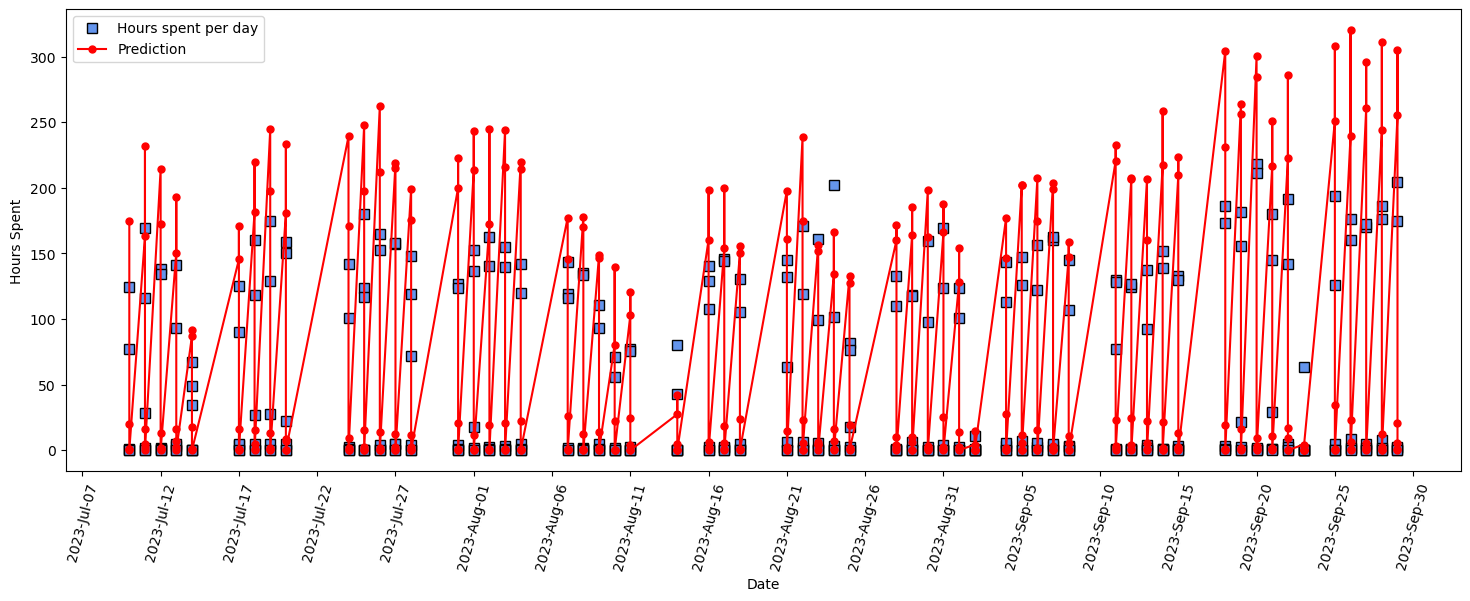

In [32]:
date = df['DATE'][train_size:]

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(date, test_y / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Hours spent per day')
ax.plot(date, yhat / 3600, 
        linestyle='-',
        marker='o',
        markersize=5,
        color='red',
        label='Prediction')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours Spent')
plt.xticks(rotation=75)
ax.legend(loc='upper left')
plt.show()

In [33]:
mae = mean_absolute_error(test_y, yhat) / 3600
print('MAE: %.3f' % mae)

MAE: 24.038
